# Field Failure Data Analysis

In [1]:
# Data Analysis
import pandas as pd
import os
import csv
import numpy as np
from scipy.optimize import curve_fit
import scipy.stats

# Data Visualization
import matplotlib.pyplot as plt

# Reliability

from reliability.Reliability_testing import KStest
from reliability.Probability_plotting import plot_points
from statsmodels.distributions.empirical_distribution import ECDF
import scipy.stats as stats

# Utilities
import os
import numpy as np
from tqdm import tnrange
from tqdm import tqdm_notebook as tqdmn


## Funzioni

In [2]:


def sensitivity_analysis(dataframe, c_wins, filepath):
    # Verifica se il file specificato esiste già
   
        print('Creazione del file', filepath, 'in corso... potrebbe richiedere del tempo.\n')
        tuples = []

        # Itera su tutte le finestre di coalescenza
        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0, 'Timestamp'])

            # Itera su tutti gli indici del dataframe tranne l'ultimo
            for index in range(dataframe.shape[0] - 1):
                succ = int(dataframe.loc[index + 1, 'Timestamp'])
                
                win = int(win)
                # Verifica se la differenza tra l'istante successivo e precedente è maggiore o uguale alla finestra
                if succ - prev >= win:
                    tup = tup + 1
                prev = succ

            tuples.append(tup)

        # Crea un nuovo dataframe contenente le finestre di coalescenza e il numero di tuple
        df_sens = pd.DataFrame(data={'Window': c_wins, 'Tuples': tuples})

        # Salva il dataframe in un file CSV
        with open(filepath, 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(df_sens.columns)  
            writer.writerows(df_sens.values)  


        return df_sens
      

In [3]:
def tupling(dataframe, c_win, filepath):
   

        print('Creazione del file', filepath, 'in corso... potrebbe richiedere del tempo.\n')
        
        tup = 0
        prev = int(dataframe.loc[0, 'Timestamp'])
        dataframe.loc[0, 'Tuple'] = 0

        # Itera su tutti gli indici del dataframe tranne l'ultimo
        for index in range(dataframe.shape[0] - 1):
            succ = int(dataframe.loc[index + 1, 'Timestamp'])
            
            # Verifica se la differenza tra l'istante successivo e precedente è maggiore o uguale alla finestra di coalescenza
            if succ - prev >= c_win:
                tup = tup + 1
            
            # Aggiorna il valore della colonna 'Tuple' nel dataframe
            dataframe.loc[index + 1, 'Tuple'] = tup
            prev = succ
            
        # Salva il dataframe in un file CSV
        dataframe.to_csv(filepath)

    
        return dataframe

In [4]:
def statistics(dataframe):
    # Creazione di un nuovo DataFrame vuoto con le colonne desiderate
    df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

    # Calcolo del numero di occorrenze per ogni valore nella colonna 'Tuple'
    df_stat['# Entries'] = dataframe.groupby(by='Tuple').count()['Timestamp']

    # Calcolo del valore minimo nella colonna 'Timestamp' per ogni valore nella colonna 'Tuple'
    df_stat['Start time'] = dataframe.groupby(by='Tuple').min(numeric_only=True)['Timestamp']

    # Calcolo del valore massimo nella colonna 'Timestamp' per ogni valore nella colonna 'Tuple'
    df_stat['End time'] = dataframe.groupby(by='Tuple').max(numeric_only=True)['Timestamp']

    # Calcolo della differenza tra 'End time' e 'Start time'
    df_stat['Length'] = df_stat['End time'] - df_stat['Start time']

    # Calcolo della densità come rapporto tra '# Entries' e 'Length'
    df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']

    # Creazione di un DataFrame temporaneo con un valore NaN nella colonna 'Start time'
    df_temp = pd.DataFrame(data={'Start time': [np.nan]})

    # Concatenazione di df_temp e df_stat per avere una riga iniziale contenente NaN
    df_temp = pd.concat([df_temp, df_stat], ignore_index=True)

    # Calcolo dell'intervallo tra 'Start time' e l'elemento precedente in 'End time'
    df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)

    return df_stat



## Upload dati Mercury 

In [5]:
# Legge il file di log 'MercuryErrorLog.txt' e lo carica nel DataFrame df_mercury.
# Assegna i nomi di colonna 'Timestamp', 'Node', 'Subsystem' e 'Message'.
df_mercury = pd.read_table('1_Mercury/MercuryErrorLog.txt', names=['Timestamp', 'Node', 'Subsystem', 'Message'])

# Esegue il parsing della colonna 'Timestamp' per estrarre il valore 'Node'.
df_mercury.loc[:, 'Node'] = df_mercury['Timestamp'].str.split(' ', n=3).str[1]

# Esegue il parsing della colonna 'Timestamp' per estrarre il valore 'Subsystem'.
df_mercury.loc[:, 'Subsystem'] = df_mercury['Timestamp'].str.split(' ', n=3).str[2]

# Esegue il parsing della colonna 'Timestamp' per estrarre il valore 'Message'.
df_mercury.loc[:, 'Message'] = df_mercury['Timestamp'].str.split(' ', n=3).str[3]

# Esegue il parsing della colonna 'Timestamp' per estrarre il valore 'Timestamp' corretto.
df_mercury.loc[:, 'Timestamp'] = df_mercury['Timestamp'].str.split(' ', n=3).str[0]

# Assegna un valore 'Type' basato sul contenuto della colonna 'Node'.
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

# Stampa il numero di righe e colonne presenti nel DataFrame df_mercury.
print('Il logfile ha ' + str(df_mercury.shape[0]) + ' entries e ' + str(df_mercury.shape[1]) + ' colonne.')

# Stampa le prime righe del DataFrame df_mercury.
df_mercury.head()



Il logfile ha 80854 entries e 5 colonne.


,Timestamp,Node,Subsystem,Message,Type
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
1,1167637660,tg-c645,PRO,Device Error Info Section,computation
2,1167637660,tg-c645,PRO,Error Map: x,computation
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,computation
4,1167637720,tg-c645,PRO,Device Error Info Section,computation


## Upload Mercury C_wins


In [6]:
# Legge il file 'tentative-Cwin.txt' e carica i dati nel DataFrame df_mercury_cwins.
# Assegna il nome di colonna 'Cwins'.
df_mercury_cwins = pd.read_table('1_Mercury/tentative-Cwin.txt', names=['Cwins'])

# Stampa le prime righe del DataFrame df_mercury_cwins.
df_mercury_cwins.head()


,Cwins
0,10
1,50
2,100
3,120
4,150


# Sistema (Mercury)

## Data Manipulation

### Coalescenza Temporale

#### Analisi di sensitività

Creazione del file 1_Mercury/Coalescenza_Temporale/Csv/Mercury-Sensitivity.csv in corso... potrebbe richiedere del tempo.



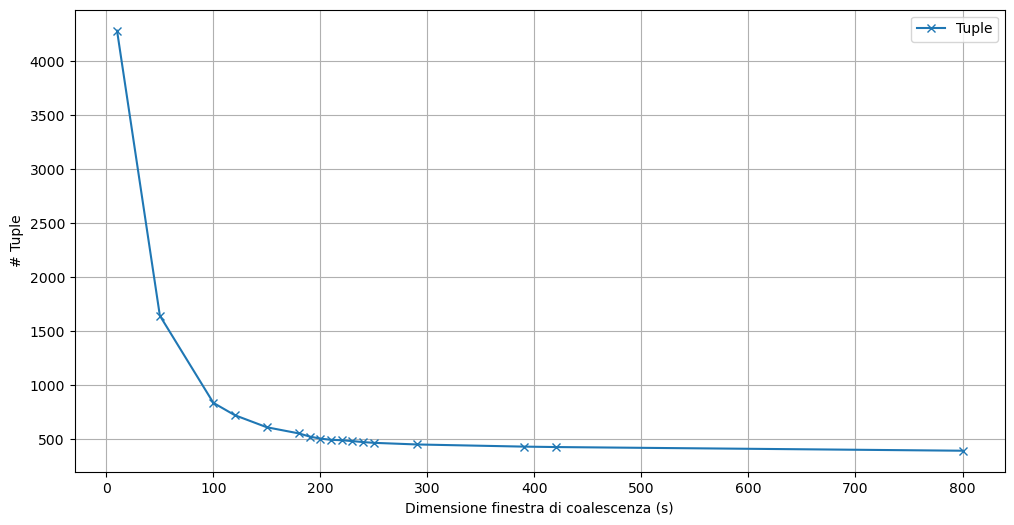

In [7]:
# Estrae i valori della colonna 'Cwins' dal DataFrame df_mercury_cwins e li assegna a c_wins.
c_wins = df_mercury_cwins['Cwins'].values

# Definisce il percorso del file CSV in cui verrà salvato il risultato dell'analisi di sensibilità.
filepath = '1_Mercury/Coalescenza_Temporale/Csv/Mercury-Sensitivity.csv'

# Esegue l'analisi di sensibilità utilizzando la funzione sensitivity_analysis, passando il DataFrame df_mercury, i valori di c_wins e il percorso del file CSV.
df_mercury_sensitivity = sensitivity_analysis(df_mercury, c_wins, filepath)


plt.figure(figsize=(12,6))

# Traccia il grafico delle colonne 'Window' e 'Tuples' del DataFrame df_mercury_sensitivity,
# assegnando l'etichetta 'Tuple' e utilizzando il marker 'x' per i punti.
plt.plot(df_mercury_sensitivity['Window'], df_mercury_sensitivity['Tuples'], label='Tuple', marker='x')

# Assegna l'etichetta 'Dimensione finestra di coalescenza (s)' all'asse x.
plt.xlabel('Dimensione finestra di coalescenza (s)')

# Assegna l'etichetta '# Tuple' all'asse y.
plt.ylabel('# Tuple')

# Mostra una legenda nel grafico.
plt.legend()

# Mostra una griglia nel grafico.
plt.grid()

# Salva il grafico in formato PNG.
plt.savefig("1_Mercury/Coalescenza_Temporale/immagini/Mercury_System_Sensitivity.png", format="png")

# Mostra il grafico.
plt.show()


#### Tupling

In [8]:
# Definisco la finestra di coalescenza con valore 200.
window = 200

# Definisce il percorso del file CSV in cui verranno salvate le tuple di Mercury.
filepath = '1_Mercury/Coalescenza_Temporale/Csv/Mercury-tuple.csv'

# Esegue la fase di tupling sul DataFrame df_mercury, utilizzando la finestra di coalescenza definita e il percorso del file CSV.
df_mercury = tupling(df_mercury, window, filepath)

# Converte le colonne 'Timestamp' e 'Tuple' del DataFrame df_mercury in tipo di dati int32.
df_mercury = df_mercury.astype({'Timestamp': 'int32', 'Tuple': 'int32'})

# Stampa le ultime righe del DataFrame df_mercury.
df_mercury.tail()


Creazione del file 1_Mercury/Coalescenza_Temporale/Csv/Mercury-tuple.csv in corso... potrebbe richiedere del tempo.



,Timestamp,Node,Subsystem,Message,Type,Tuple
80849,1174943008,tg-c196,I-O,hda: packet command error: error=x,computation,506
80850,1174943068,tg-c128,I-O,hda: packet command error: error=x,computation,506
80851,1174943068,tg-c128,I-O,hda: packet command error: error=x,computation,506
80852,1174943925,tg-c196,NET,connection down,computation,507
80853,1174943943,tg-c196,I-O,hda: packet command error: error=x,computation,507


In [9]:
# Calcola il numero massimo di tuple presente nella colonna 'Tuple' del DataFrame df_mercury.
num_tuple = df_mercury.max(axis=0).loc['Tuple'] + 1

# Stampa il numero di tuple calcolato.
print('Numero di tuple:', num_tuple)


Numero di tuple: 508


In [10]:
df_sys_stat = statistics(df_mercury)
df_sys_stat.head()

,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,
0,6,1167637660,1167637720,60,0.1,NaN
1,3,1167655228,1167655229,1,3,17508
2,61,1167657137,1167657302,165,0.369697,1908
3,14,1167657550,1167657550,0,inf,248
4,2,1167657941,1167657941,0,inf,391


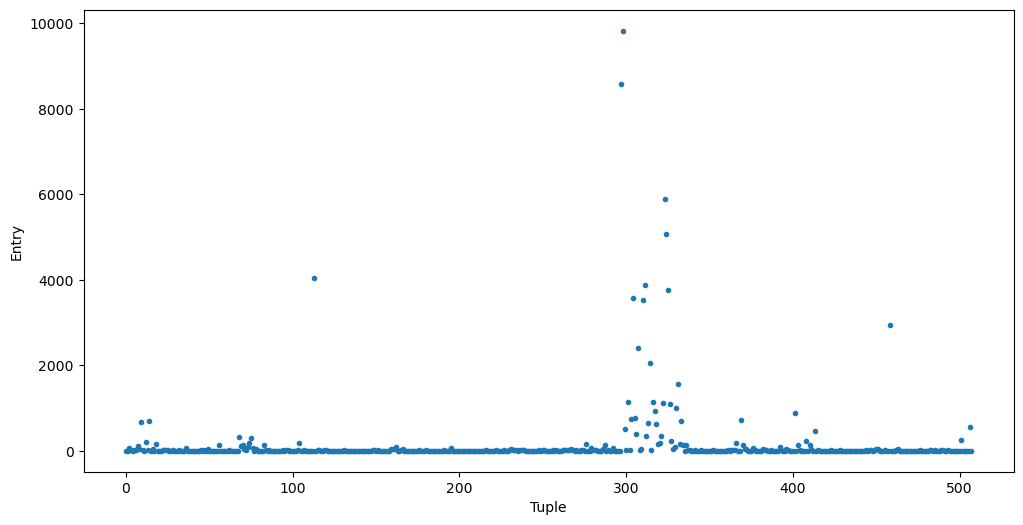

In [11]:
# Aggiungi una colonna 'Riga' contenente il numero di riga corrispondente
df_sys_stat.insert(0, 'Tupla', range(1, len(df_sys_stat) + 1))

# Salva il DataFrame sul file CSV con la riga numerata come prima riga
df_sys_stat.to_csv("1_Mercury/Coalescenza_Temporale/Csv/valori_tuple.csv", index=False)

# Trova gli indici delle righe con il numero massimo di '# Entries'
max_entries_indices = df_sys_stat[df_sys_stat['# Entries'] == df_sys_stat['# Entries'].max()].index

# Filtra il DataFrame originale utilizzando gli indici delle righe con il numero massimo di '# Entries'
df_max_entries_range = df_sys_stat.loc[max_entries_indices]

# Aggiungi una colonna 'Riga Tupla' contenente il numero di riga corrispondente
df_max_entries_range['Riga Tupla'] = df_max_entries_range.index

# Salva il DataFrame filtrato sul file CSV
df_max_entries_range.to_csv("1_Mercury/Coalescenza_Temporale/Csv/max_entries_range.csv", index=False)

# Plot
x = df_sys_stat.index
y = df_sys_stat['# Entries']

plt.figure(figsize=(12, 6))
plt.scatter(x, y, marker='.')
plt.xlabel('Tuple')
plt.ylabel('Entry')

plt.savefig("1_Mercury/Coalescenza_Temporale/immagini/Mercury_System_Scatter_Riga_Entry.png", format="png")
plt.show()


#### Bottleneck

In [12]:
# Definizione dei valori di inizio e fine per la selezione del sottoinsieme di dati
start_tup = 298
end_tup = 334

# Seleziona le righe del DataFrame df_mercury che hanno un valore di 'Tuple' compreso tra start_tup e end_tup
df_bottleneck = df_mercury.loc[(df_mercury['Tuple'] >= start_tup) & (df_mercury['Tuple'] <= end_tup)]

# Visualizza le prime righe del DataFrame df_bottleneck
df_bottleneck.head()


,Timestamp,Node,Subsystem,Message,Type,Tuple
18752,1171337536,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,298
18753,1171337536,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,298
18754,1171337536,tg-c401,DEV,"Component Info: Vendor Id =x x, Device Id =x x...",computation,298
18755,1171337537,tg-c401,DEV,+END HARDWARE ERROR STATE AT CPE,computation,298
18756,1171337537,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,298


In [19]:
import datetime

def timestamp_to_date(timestamp):
    # Converti il timestamp in un oggetto datetime
    dt = datetime.datetime.fromtimestamp(timestamp)
    
    # Formatta la data come stringa nel formato desiderato
    date_string = dt.strftime('%d-%m-%Y %H:%M:%S')
    
    return date_string

timestamp_tup_298 = 1171321113  
timestamp_tup_334 = 1171484600

tup_298 = timestamp_to_date(timestamp_tup_298)
print('Inizio:',tup_298)  
tup_334 = timestamp_to_date(timestamp_tup_334)
print('Fine:',tup_334) 




def Differenza_tra_ore(date1, date2):
    # Converti le date in oggetti datetime
    dt1 = datetime.datetime.strptime(date1, '%d-%m-%Y %H:%M:%S')
    dt2 = datetime.datetime.strptime(date2, '%d-%m-%Y %H:%M:%S')
    
    # Calcola la differenza tra le due date
    diff = dt2 - dt1
    
    # Estrai il numero di ore dalla differenza
    ore = diff.total_seconds() / 3600
    
    return ore

date1 = tup_298
date2 = tup_334

Differenza = Differenza_tra_ore(date1, date2)
print('Sono passate :',Differenza,  str('ore'))

Inizio: 12-02-2007 23:58:33
Fine: 14-02-2007 21:23:20
Sono passate : 45.41305555555556 ore


In [20]:
# Raggruppa il DataFrame df_bottleneck per la colonna 'Node' e conta il numero di occorrenze per ogni valore di 'Node'
# Quindi, ordina i risultati in ordine decrescente
df_bottleneck.groupby(by='Node').Timestamp.count().sort_values(ascending=False)


Node
tg-c401      53694
tg-login3      143
tg-login1      142
tg-master      100
tg-s176         10
tg-c106          7
tg-c781          6
tg-c407          4
tg-c027          3
tg-c669          3
tg-login2        2
tg-login4        2
tg-s044          2
Name: Timestamp, dtype: int64

In [21]:
# Seleziona le righe del DataFrame df_bottleneck in cui il valore nella colonna 'Node' è uguale a 'tg-c401'
df_bottleneck = df_bottleneck.loc[df_bottleneck['Node'] == 'tg-c401']

# Visualizza le prime righe del DataFrame df_bottleneck
df_bottleneck.head()

,Timestamp,Node,Subsystem,Message,Type,Tuple
18752,1171337536,tg-c401,DEV,+BEGIN HARDWARE ERROR STATE AT CPE,computation,298
18753,1171337536,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,298
18754,1171337536,tg-c401,DEV,"Component Info: Vendor Id =x x, Device Id =x x...",computation,298
18755,1171337537,tg-c401,DEV,+END HARDWARE ERROR STATE AT CPE,computation,298
18756,1171337537,tg-c401,DEV,+Platform PCI Component Error Info Section,computation,298


### Coalescenza Spaziale

In [22]:
# Imposta il valore della colonna 'Type' a 'login' per le righe in cui il valore nella colonna 'Node' contiene 'login'
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'

# Imposta il valore della colonna 'Type' a 'computation' per le righe in cui il valore nella colonna 'Node' contiene 'c'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'

# Imposta il valore della colonna 'Type' a 'storage' per le righe in cui il valore nella colonna 'Node' contiene 's'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'

# Imposta il valore della colonna 'Type' a 'master' per le righe in cui il valore nella colonna 'Node' contiene 'master'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'


In [23]:
# Calcola il numero di nodi unici nel DataFrame df_mercury nella colonna 'Node' e stampa il risultato
print('Numero di nodi che generano errori: ' + str(len(df_mercury['Node'].unique())))


Numero di nodi che generano errori: 53


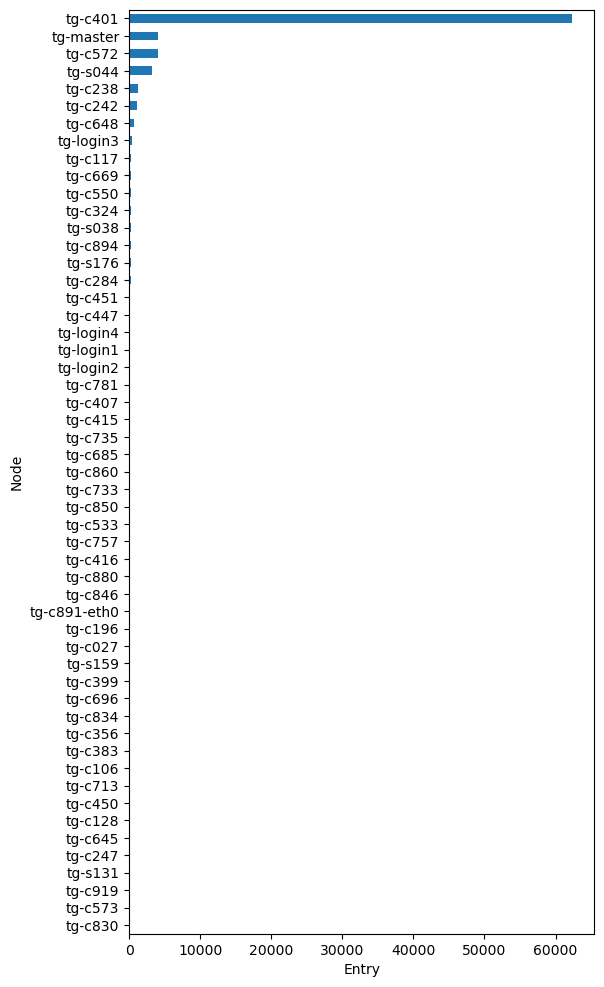

In [24]:
# Calcolo del numero di ingressi per ciascun nodo e li ordina in modo crescente
num_entries = df_mercury.groupby(by='Node').Timestamp.count().sort_values()

# Creazione del grafico a barre orizzontali
plt.figure(figsize=(6, 12))
num_entries.plot.barh()
plt.xlabel('Entry')

# Salvataggio del grafico 
plt.savefig("1_Mercury/Coalescenza_Spaziale/immagini/Mercury_System_Bar_Node.png", format="png")
plt.show()

# Calcolo del numero di ingressi per ciascun nodo e ordinamento in modo decrescente
num_entries2 = df_mercury.groupby(by='Node').Timestamp.count().sort_values(ascending=False)

# Creazione del DataFrame per la tabella
df_entries = pd.DataFrame({'Node': num_entries2.index, 'Entries': num_entries2.values})

# Salvataggio della tabella in formato CSV
table_filepath = '1_Mercury/Coalescenza_Spaziale/Csv/Mercury_System_Node_Entries.csv'
df_entries.to_csv(table_filepath, index=False)


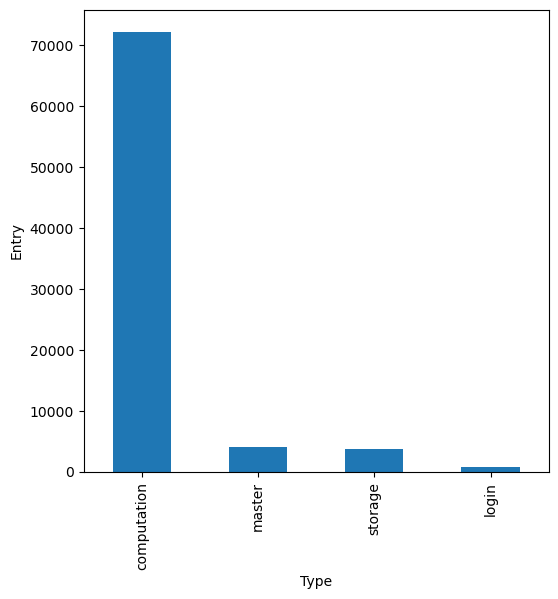

In [25]:
# Creazione del grafico a barre per il conteggio di ingressi per ogni tipo
plt.figure(figsize=(6, 6))
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending=False).plot.bar()
plt.ylabel('Entry')

# Salvataggio del grafico 
plt.savefig("1_Mercury/Coalescenza_Spaziale/immagini/Mercury_System_Bar_Type.png", format="png")
plt.show()

# Creazione del DataFrame per i valori di conteggio per ogni tipo
df_type_counts = pd.DataFrame({
    'Type': df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending=False).index,
    'Entry': df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending=False).values
})

# Salvataggio dei valori in formato CSV
csv_filepath = '1_Mercury/Coalescenza_Spaziale/Csv/Mercury_System_Type_Entry.csv'
df_type_counts.to_csv(csv_filepath, index=False)


### Coalescenza basata sui contenuti

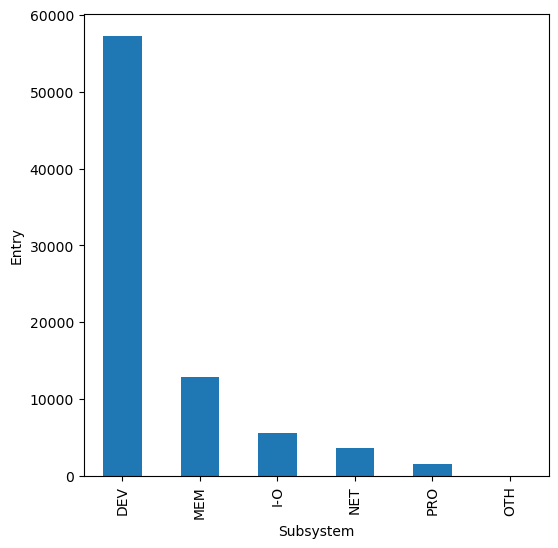

In [26]:
# Creazione del grafico a barre per il conteggio di ingressi per ogni sottosistema
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending=False).plot.bar(figsize=(6, 6))
plt.ylabel('Entry')

# Salvataggio del grafico su file PNG
plt.savefig("1_Mercury/Coalescenza_Contenuti/immagini/Mercury_System_Bar_Subsystem.png", format="png")
plt.show()

# Creazione del DataFrame per i valori di conteggio per ogni sottosistema
df_subsystem_counts = pd.DataFrame({
    'Subsystem': df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending=False).index,
    'Entry': df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending=False).values
})

# Salvataggio dei valori in formato CSV
csv_filepath = '1_Mercury/Coalescenza_Contenuti/Csv/Mercury_System_Subsystem_Entry.csv'
df_subsystem_counts.to_csv(csv_filepath, index=False)


In [27]:
# Fare altre osservazioni
df_mercury.groupby(by=['Subsystem','Type']).count()

Timestamp   Node  Message  Tuple
Subsystem Type                                         
DEV       computation      57037  57037    57037  57037
          master               3      3        3      3
          storage            208    208      208    208
I-O       computation        802    802      802    802
          login              820    820      820    820
          master             452    452      452    452
          storage           3473   3473     3473   3473
MEM       computation      12818  12818    12818  12818
          master               1      1        1      1
NET       computation         56     56       56     56
          login                3      3        3      3
          master            3639   3639     3639   3639
          storage              4      4        4      4
OTH       computation         17     17       17     17
          master               3      3        3      3
          storage             14     14       14     14
PRO       computation       1504   1504     1504   1504

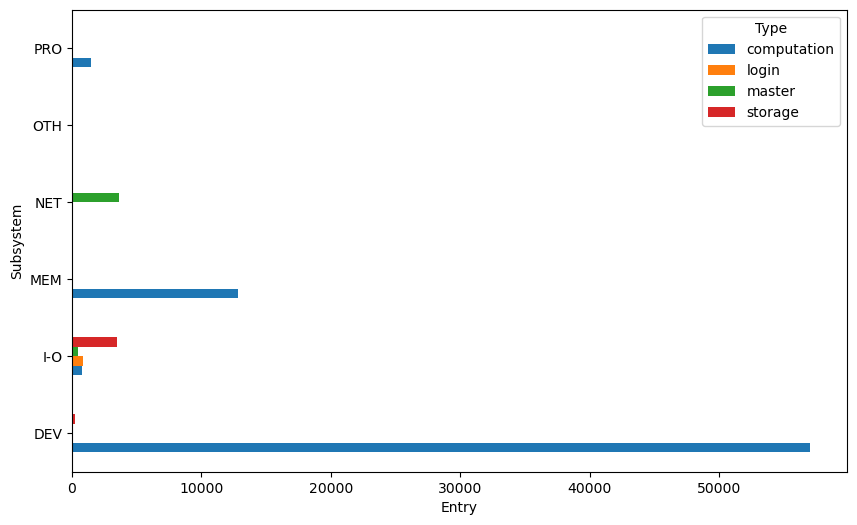

In [28]:
# Raggruppamento dei dati per sottosistema e tipo
df_counts = df_mercury.groupby(by=['Subsystem', 'Type']).Timestamp.count().unstack(1)

# Creazione del grafico a barre orizzontale
df_counts.plot.barh(figsize=(10, 6))
plt.xlabel('Entry')

# Salvataggio del grafico su file PNG
plt.savefig("1_Mercury/Coalescenza_Contenuti/immagini/Mercury_System_Bar_Subsys_Type.png", format="png")
plt.show()


### Analisi dei troncamenti

In [29]:
#si calcola il valore q corrispondente al 10° percentile (0.1 quantile) dei tempi di interarrivo.
# Calcolo del quantile 0.1 della colonna 'Interarrival' del DataFrame df_sys_stat
q = df_sys_stat['Interarrival'].quantile(q=0.1)

# Stampa del valore del quantile
print("0.1 quantile: " + str(q))
#fare confrontro con finestra di coalescenza e vedere quanto è differente, NB i valori sono in secondi convertire in minuti

0.1 quantile: 280.6


In [30]:
# Filtraggio del DataFrame df_sys_stat utilizzando la condizione 'Interarrival' <= q
df_trunc = df_sys_stat.loc[df_sys_stat['Interarrival'] <= q]

# Visualizzazione delle prime righe del DataFrame df_trunc
df_trunc.head()


,Tupla,# Entries,Start time,End time,Length,Density,Interarrival
Tuple,,,,,,,
3,4,14,1167657550,1167657550,0,inf,248
5,6,11,1167658201,1167658201,0,inf,260
6,7,16,1167658404,1167658456,52,0.307692,203
8,9,42,1167659488,1167659772,284,0.147887,211
9,10,680,1167660001,1167665307,5306,0.128157,229


In [31]:
# Raggruppamento del DataFrame df_mercury per le colonne 'Tuple' e 'Node' e conteggio delle righe per ogni gruppo
df_group = df_mercury.groupby(by=['Tuple', 'Node']).count()

# Visualizzazione delle ultime righe del DataFrame df_group
df_group.tail()


Timestamp  Subsystem  Message  Type
Tuple Node                                          
505   tg-master          4          4        4     4
506   tg-c128            2          2        2     2
      tg-c196            2          2        2     2
      tg-master        558        558      558   558
507   tg-c196            2          2        2     2

In [32]:
#Una stima potenzialmente più precisa può essere effettuata considerando tra le 
#tuple precedentemente individuate solo quelle per cui il nodo di origine più frequente è lo stesso di quello della tupla precedente.

df_group = df_group.reset_index()

# Inizializza una variabile truncated con valore 0
truncated = 0

# Esegue un ciclo for sui valori dell'indice del DataFrame df_trunc
for tup in df_trunc.index:

    # Filtra df_group in base al valore dell'indice corrente tup
    df_tup = df_group.loc[df_group.index == tup]

    # Recupera il valore del nodo con il timestamp massimo nella colonna Timestamp
    node = df_tup.loc[df_tup['Timestamp'] == df_tup.max()['Timestamp'], 'Node'].item()

    # Filtra df_group in base al valore dell'indice precedente (tup - 1)
    df_tup_prec = df_group.loc[df_group.index == tup - 1]

    # Recupera il valore del nodo con il timestamp massimo nella colonna Timestamp
    node_prec = df_tup_prec.loc[df_tup_prec['Timestamp'] == df_tup_prec.max()['Timestamp'], 'Node'].item()

    # Se i valori dei nodi sono uguali, incrementa il valore di truncated di 1
    if node == node_prec:
        truncated = truncated + 1

In [33]:
perc_trunc = (truncated/num_tuple)*100

print('Troncamenti:', truncated)
print('Percentuale di troncamenti:', perc_trunc)

Troncamenti: 24
Percentuale di troncamenti: 4.724409448818897


### Analisi delle Collisioni

In [34]:
df_group = df_mercury.groupby(by=['Tuple','Node']).count()
df_group.tail()

Timestamp  Subsystem  Message  Type
Tuple Node                                          
505   tg-master          4          4        4     4
506   tg-c128            2          2        2     2
      tg-c196            2          2        2     2
      tg-master        558        558      558   558
507   tg-c196            2          2        2     2

In [35]:
collided = 0

# Itera sui valori unici del primo livello dell'indice nel DataFrame df_group
for tup in df_group.index.levels[0]:
    # Se il numero di righe che corrispondono alla tupla è maggiore di 1, incrementa il contatore delle collisioni
    if df_group.loc[tup].shape[0] > 1:
        collided += 1

print('Collisioni:', collided)



Collisioni: 47


In [36]:
perc_coll = (collided/num_tuple)*100

print('Collisioni:', collided)
print('Percentuale di collisioni: ', perc_coll)

Collisioni: 47
Percentuale di collisioni:  9.251968503937007


## Data Analysis

### Distribuzione empirica del tempo fino al Faulire

### Da fare su matlab

### Empirical reliability

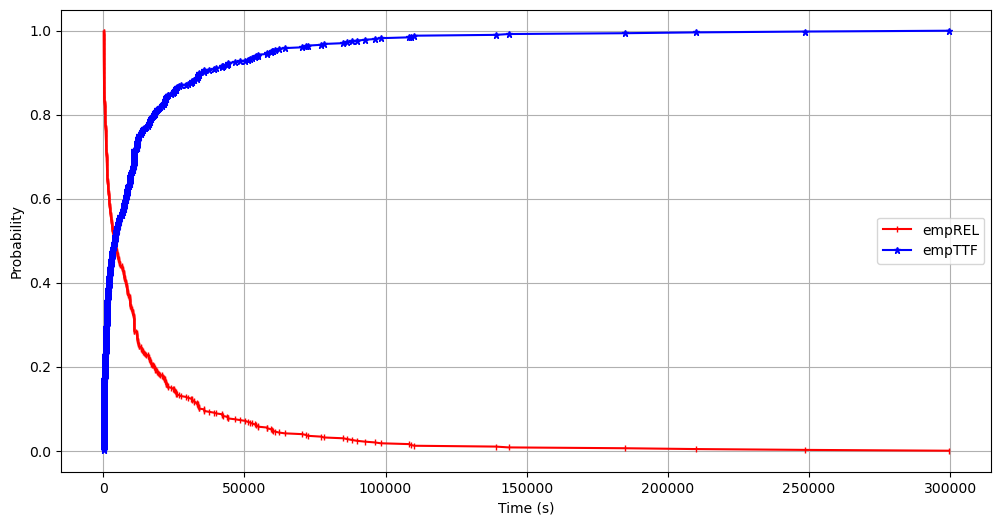

In [37]:

data = df_sys_stat['Interarrival'].dropna().to_numpy()
ecdf = ECDF(data)
# Save ECDF values to a CSV file
ecdf_data = pd.DataFrame({'x': ecdf.x, 'empREL': 1 - ecdf.y, 'empTTF': ecdf.y})
ecdf_data.to_csv('1_Mercury/ecdf_data.csv', index=False)
ecdf_data = pd.DataFrame({'t': ecdf.x})
ecdf_data.to_csv('1_Mercury/t_ecdf_data.csv', index=False)
plt.figure(figsize=(12,6))

# Tracciamento del grafico dell'empirical reliability in rosso con il simbolo '|'
plt.plot(ecdf.x, 1-ecdf.y, color='red', marker='|',markersize=5, label='empREL')

# Tracciamento del grafico dell'empirical TTF in viola con il simbolo '*'
plt.plot(ecdf.x, ecdf.y, color='blue', marker='*',markersize=5, label='empTTF')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("1_Mercury/Mercury_System_Emp_Reliability.png", format = "png")
plt.show()

#tempo = pd.DataFrame(data = ecdf.x, columns=['tempo'])
#rel = pd.DataFrame(data = 1-ecdf.y, columns=['reliability'])
#tempo.to_csv('1_Mercury/tempo_Mercury_system.csv', index=False)
#rel.to_csv('1_Mercury/reliability_Mercury_system.csv', index=False)


#tempi_int = pd.DataFrame(df_sys_stat['Interarrival'].dropna().to_numpy(), columns=['tempi interarrivo'])
#tempi_int.to_csv('1_Mercury/tempi_int.csv', index=False)

# Sotto Sistemi


In [38]:
subsystems = df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False)
print(subsystems)

Subsystem
DEV    57248
MEM    12819
I-O     5547
NET     3702
PRO     1504
OTH       34
Name: Timestamp, dtype: int64


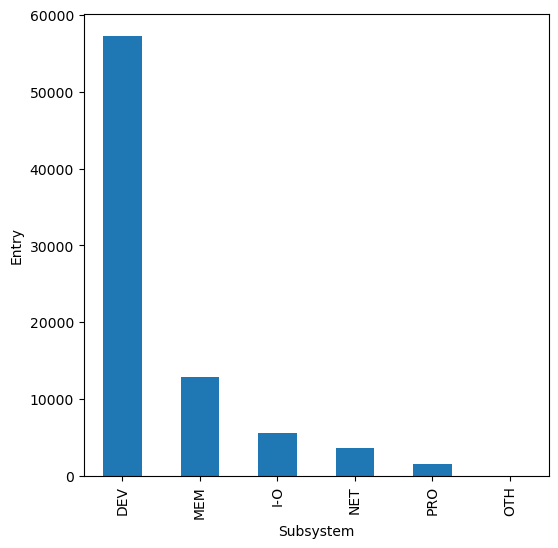

In [39]:
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar(figsize=(6,6))
plt.ylabel('Entry')
plt.show()

## Data Manipulation

### Coalescenza Temporale per categoria

#### Sensitivity analysis

In [40]:
# Legge il file 'tentative-Cwin.txt' e carica i dati nel DataFrame df_mercury_cwins.
# Assegna il nome di colonna 'Cwins'.
df_mercury_cwins = pd.read_table('1_Mercury/tentative-Cwin.txt', names=['Cwins'])

# Stampa le prime righe del DataFrame df_mercury_cwins.
df_mercury_cwins.head()
c_wins = df_mercury_cwins['Cwins'].values
for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = '1_Mercury/SottoSistema//PerCategoria/Analisi_Sensitività/Mercury-' + subsys + '-Sensitivity.csv'
    
    sensitivity_analysis(df_temp, c_wins, filepath)

Creazione del file 1_Mercury/SottoSistema//PerCategoria/Analisi_Sensitività/Mercury-DEV-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema//PerCategoria/Analisi_Sensitività/Mercury-MEM-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema//PerCategoria/Analisi_Sensitività/Mercury-I-O-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema//PerCategoria/Analisi_Sensitività/Mercury-NET-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema//PerCategoria/Analisi_Sensitività/Mercury-PRO-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema//PerCategoria/Analisi_Sensitività/Mercury-OTH-Sensitivity.csv in corso... potrebbe richiedere del tempo.



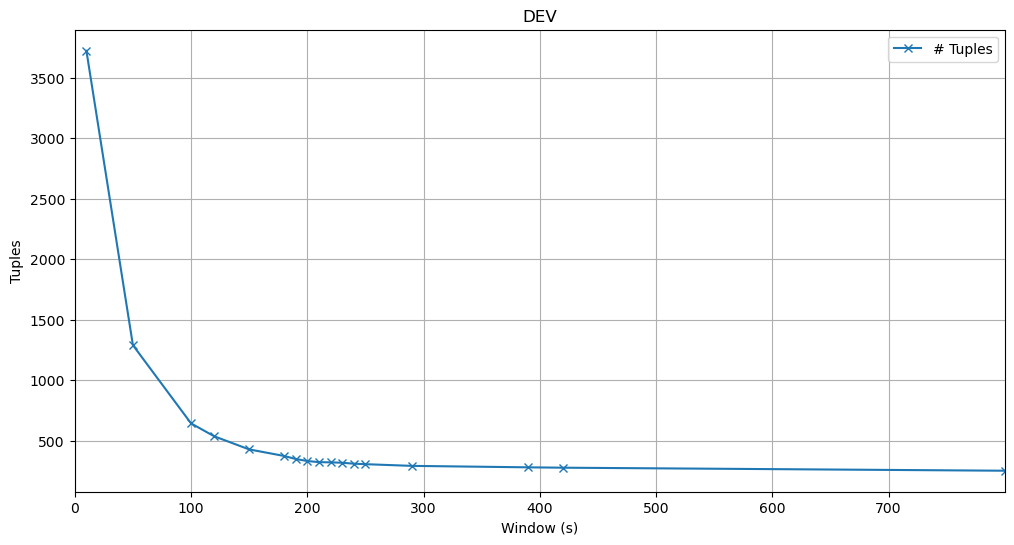

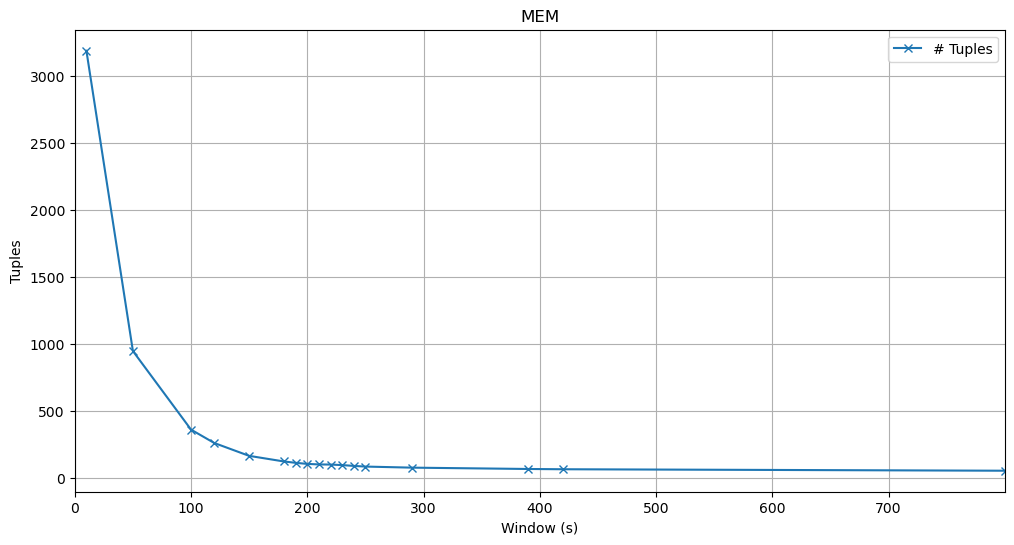

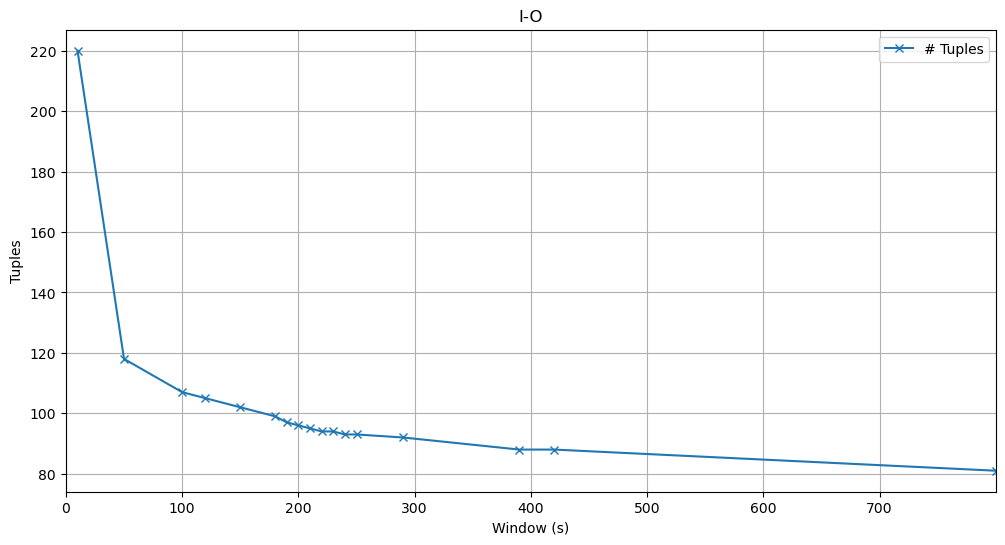

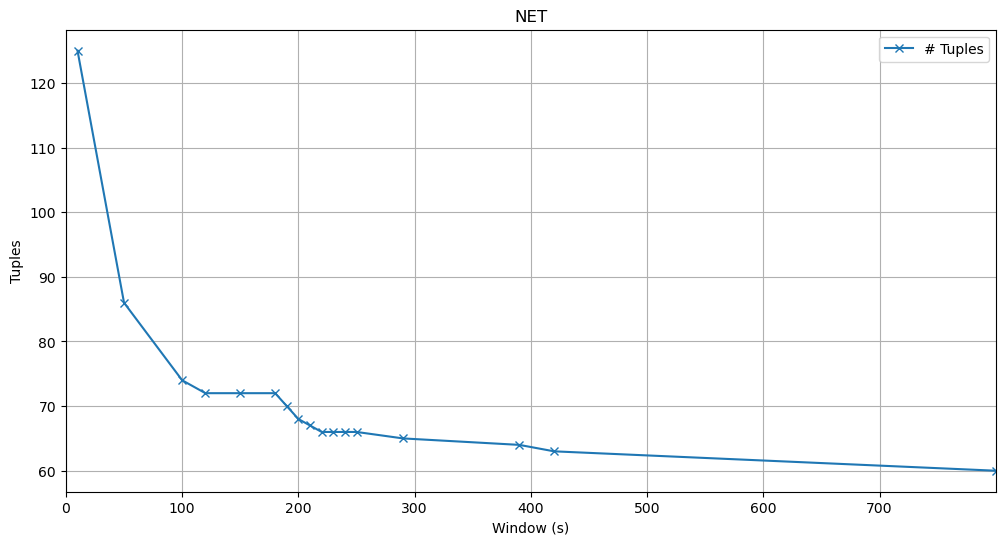

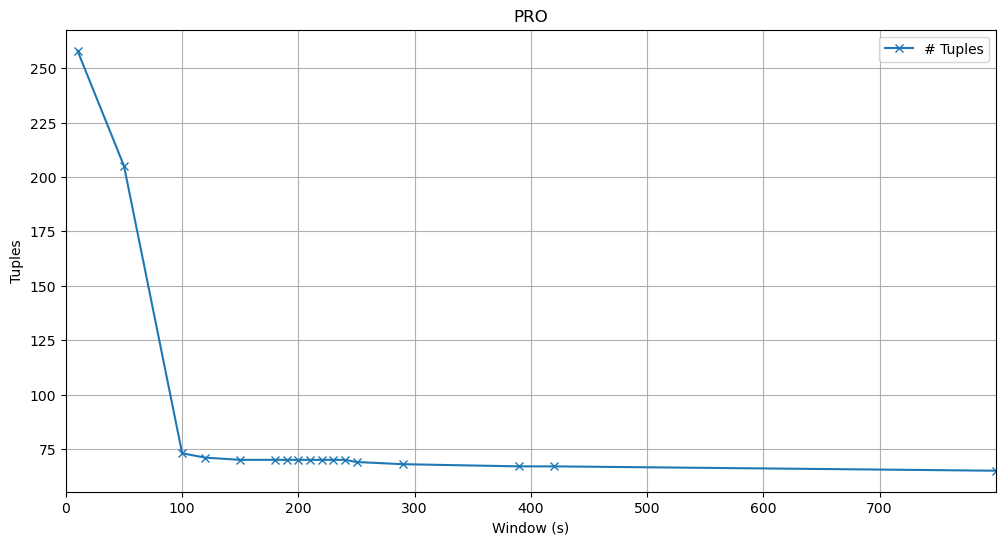

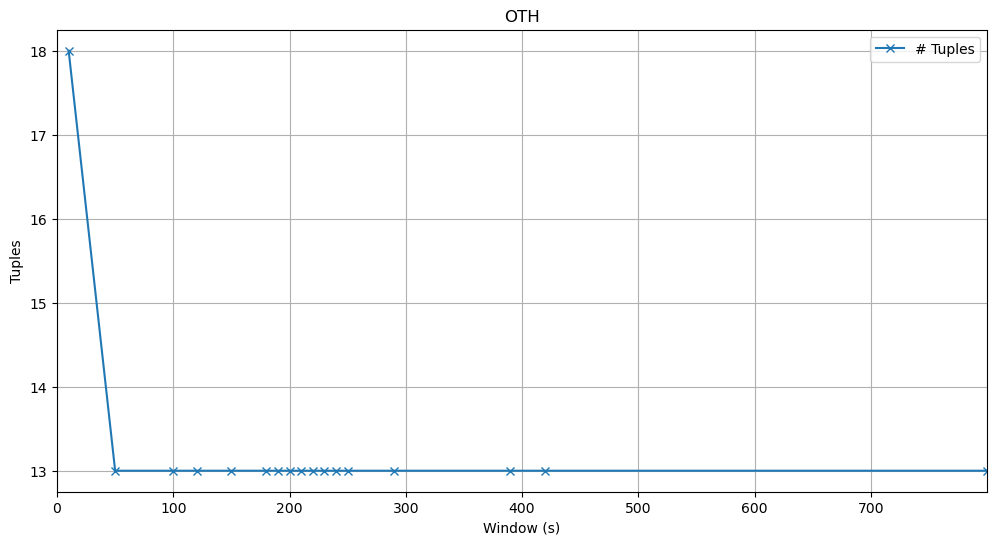

In [41]:
for subsys in subsystems.index:
    filepath = '1_Mercury/SottoSistema/PerCategoria/Analisi_Sensitività/Mercury-' + subsys + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col=0)
    #print(df_temp_sensitivity.head())
    
    x = df_temp_sensitivity.index
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples', marker='x')
    plt.title(subsys)
    plt.xlim(0,800)
    plt.xticks(np.arange(0, 800, step = 100))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("1_Mercury/SottoSistema/PerCategoria/Analisi_Sensitività/immagini/Mercury_Subsystem_Sensitivity_" + subsys + ".png", format = "png")
    plt.show()

In [42]:
win_dict = {'DEV' : 200,
            'MEM' : 200,
            'I-O' : 100,
            'NET' : 100,
            'PRO' : 100,
            'OTH' : 100}
print('Finestre di coalescenza selezionate:', win_dict)

Finestre di coalescenza selezionate: {'DEV': 200, 'MEM': 200, 'I-O': 100, 'NET': 100, 'PRO': 100, 'OTH': 100}


#### Tupling

In [43]:
dict_df_cat_stat = {}
dict_cat_num_tup = {}

for subsys in subsystems.index:
    df_temp = df_mercury.loc[df_mercury['Subsystem'] == subsys]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = '1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury-' + subsys + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[subsys], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_cat_num_tup[subsys] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_cat_stat[subsys] = df_stat

print('Numero di tuple:', dict_cat_num_tup)

Creazione del file 1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury-DEV-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury-MEM-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury-I-O-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury-NET-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury-PRO-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury-OTH-Data.csv in corso... potrebbe richiedere del tempo.

Numero di tuple: {'DEV': 334, 'MEM': 105, 'I-O': 107, 'NET': 74, 'PRO': 73, 'OTH': 13}


## Data Analysis

### Distribuzione empirica del tempo fino al Faulire

### Da fare su matlab

### Empirical reliability

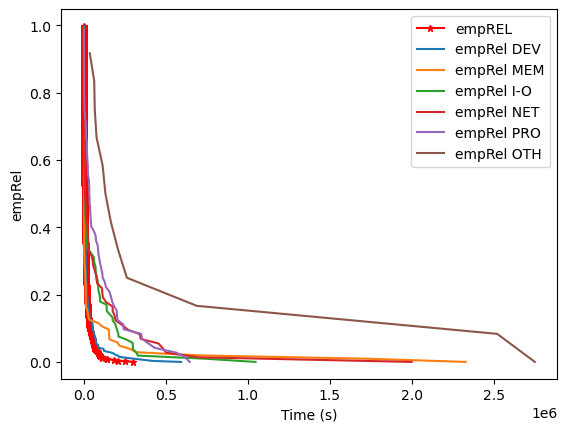

In [44]:


data = df_sys_stat['Interarrival'].dropna().to_numpy()
ecdf2 = ECDF(data)
# Tracciamento del grafico dell'empirical reliability in rosso con il simbolo '|'
plt.plot(ecdf2.x, 1-ecdf2.y, color='red', marker='*', markersize=5, label='empREL')

# Create a DataFrame to store the interarrival data for each index
interarrival_data = pd.DataFrame()

for subsys in subsystems.index:
    ecdf = ECDF(dict_df_cat_stat[subsys]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label='empRel ' + str(subsys))
    plt.xlabel('Time (s)')
    plt.ylabel('empRel')
    plt.legend()
    plt.grid()

    # Store the interarrival data in the DataFrame
    interarrival_data['Interarrival_' + str(subsys)] = dict_df_cat_stat[subsys]['Interarrival'].dropna()

# Save the DataFrame to a CSV file
interarrival_data.to_csv("1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury_Subsystem_Interarrival.csv", index=False)

plt.savefig("1_Mercury/SottoSistema/PerCategoria/Tuple/Mercury_Subsystem_Emp_Reliability.png", format="png")




# Top nodi

In [45]:
print('Numero di nodi che generano errore: ' + str(len(df_mercury['Node'].unique())))

Numero di nodi che generano errore: 53


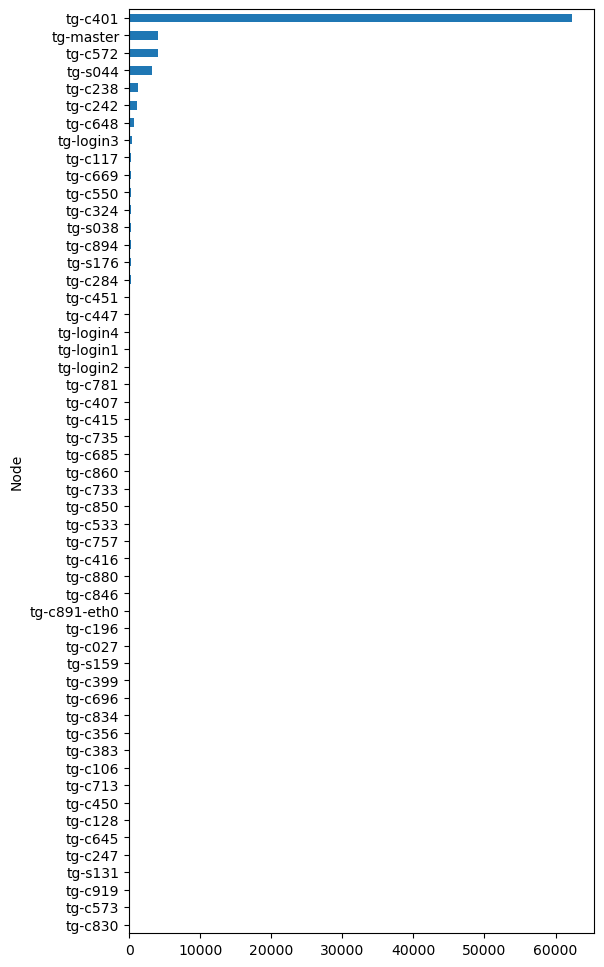

In [46]:
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh(figsize=(6,12))
plt.show()

In [47]:
top_5 = df_mercury.groupby(by='Node').Timestamp.count().sort_values(ascending = False)[0:5]
top_5

Node
tg-c401      62340
tg-master     4098
tg-c572       4030
tg-s044       3224
tg-c238       1273
Name: Timestamp, dtype: int64

### Coalescenza temporale per nodo

#### Analisi di sensitività

In [48]:
# Legge il file 'tentative-Cwin.txt' e carica i dati nel DataFrame df_mercury_cwins.
# Assegna il nome di colonna 'Cwins'.
df_mercury_cwins = pd.read_table('1_Mercury/tentative-Cwin.txt', names=['Cwins'])

# Stampa le prime righe del DataFrame df_mercury_cwins.
df_mercury_cwins.head()
c_wins = df_mercury_cwins['Cwins'].values

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = '1_Mercury/SottoSistema/PerNodo/Analisi_sensitività/Mercury-' + node + '-Sensitivity.csv'
    sensitivity_analysis(df_temp, c_wins, filepath)

Creazione del file 1_Mercury/SottoSistema/PerNodo/Analisi_sensitività/Mercury-tg-c401-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerNodo/Analisi_sensitività/Mercury-tg-master-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerNodo/Analisi_sensitività/Mercury-tg-c572-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerNodo/Analisi_sensitività/Mercury-tg-s044-Sensitivity.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerNodo/Analisi_sensitività/Mercury-tg-c238-Sensitivity.csv in corso... potrebbe richiedere del tempo.



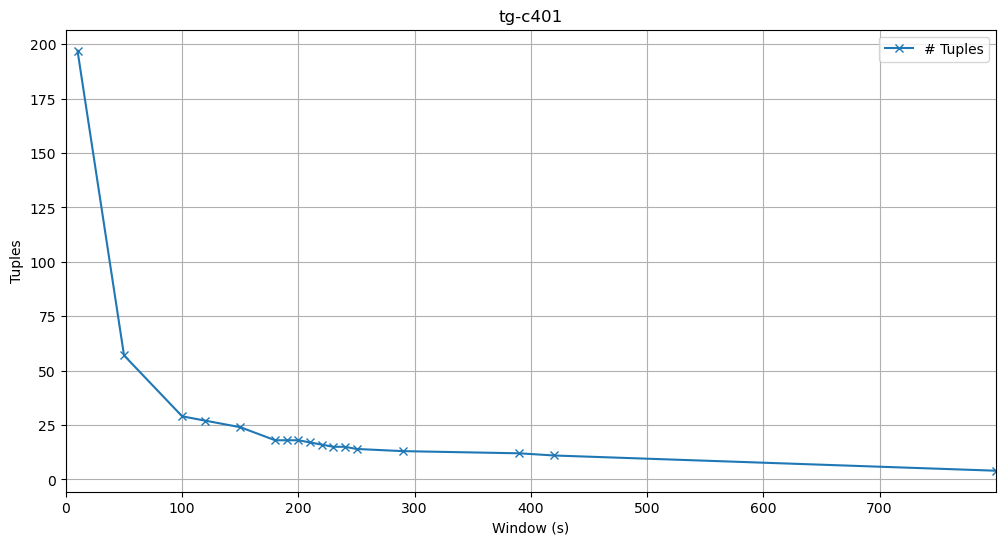

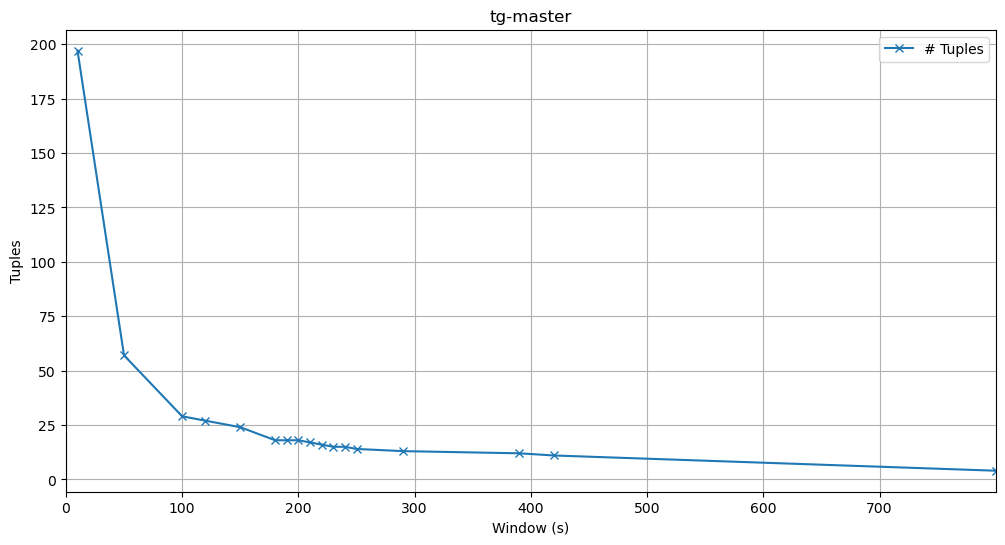

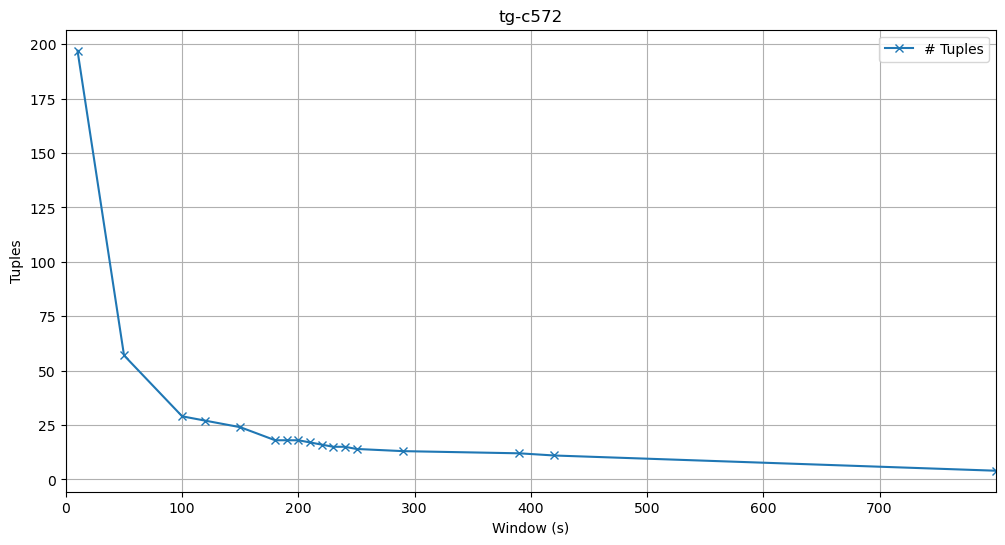

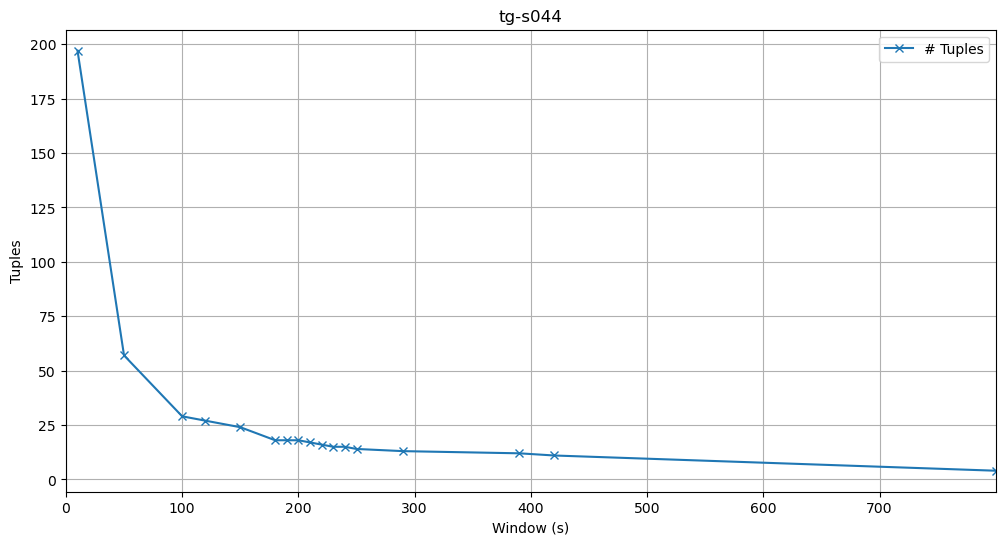

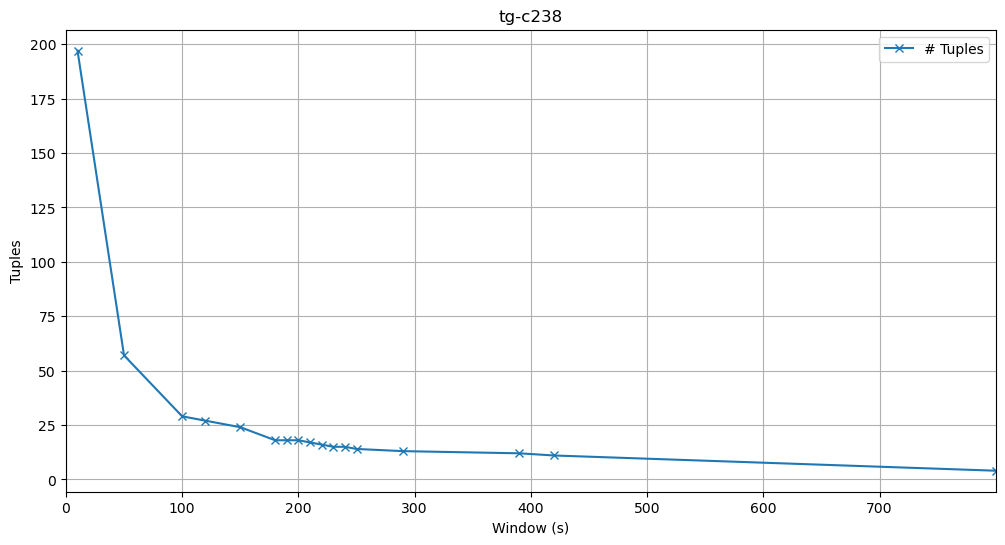

In [52]:
for t in top_5.index:
    filepath = '1_Mercury/SottoSistema/PerNodo/Analisi_sensitività/Mercury-' + node + '-Sensitivity.csv'
    
    df_temp_sensitivity = pd.read_csv(filepath, index_col = 0)
    
    x = df_temp_sensitivity.index
    y = df_temp_sensitivity['Tuples']
    
    plt.figure(figsize=(12,6))
    plt.plot(x, y, label = '# Tuples',marker='x')
    plt.title(t)
    plt.xlim(0,800)
    plt.xticks(np.arange(0, 800, step = 100))
    plt.xlabel('Window (s)')
    plt.ylabel('Tuples')
    plt.legend()
    plt.grid()
    plt.savefig("1_Mercury/SottoSistema/PerNodo/Analisi_Sensitività/immagini/Mercury_Type_Sensitivity_" + t + ".png", format = "png")

In [57]:
win_dict = {  'tg-c401' : 190,
              'tg-master' : 200,
              'tg-c572' : 200,
              'tg-s044' : 200,
              'tg-c238' : 200}

print('Finestre di coalescenza selezionate:', win_dict)

Finestre di coalescenza selezionate: {'tg-c401': 190, 'tg-master': 200, 'tg-c572': 200, 'tg-s044': 200, 'tg-c238': 200}


#### Tupling

In [58]:
dict_df_node_stat = {}
dict_node_num_tup = {}

for node in top_5.index:
    df_temp = df_mercury.loc[df_mercury['Node'] == node]
    df_temp.reset_index(drop = True, inplace = True)

    filepath = '1_Mercury/SottoSistema/PerNodo/Tuple/Mercury-' + node + '-Data.csv'
    
    df_tupling = tupling(df_temp, win_dict[node], filepath)
    num_tup = df_tupling.max(axis = 0).loc['Tuple'] + 1
    dict_node_num_tup[node] = num_tup
    
    df_stat = statistics(df_tupling)
    dict_df_node_stat[node] = df_stat
    
print('Numero di tuple:', dict_node_num_tup)

Creazione del file 1_Mercury/SottoSistema/PerNodo/Tuple/Mercury-tg-c401-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerNodo/Tuple/Mercury-tg-master-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerNodo/Tuple/Mercury-tg-c572-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerNodo/Tuple/Mercury-tg-s044-Data.csv in corso... potrebbe richiedere del tempo.

Creazione del file 1_Mercury/SottoSistema/PerNodo/Tuple/Mercury-tg-c238-Data.csv in corso... potrebbe richiedere del tempo.

Numero di tuple: {'tg-c401': 63, 'tg-master': 60, 'tg-c572': 2, 'tg-s044': 10, 'tg-c238': 18}


## Data Analysis

### Distribuzione empirica del tempo fino al Faulire

### Da fare su matlab

### Empirical reliability

In [ ]:
plt.figure(figsize=(12,6))
top_2 = [k for k in dict_node_num_tup if dict_node_num_tup[k] > 30]   
for node in top_2:
    ecdf = ECDF(dict_df_node_stat[node]['Interarrival'].dropna())

    plt.plot(ecdf.x, 1-ecdf.y, label = 'empRel ' + str(node))

plt.xlabel('Time (s)')
plt.ylabel('empRel')
plt.legend()
plt.grid()
plt.savefig("1_Mercury/SottoSistema/PerNodo/Mercury_Top_Emp_Reliability.png", format = "png")

tempo = pd.DataFrame(data = np.delete(ECDF(dict_df_node_stat['tg-c401']['Interarrival'].dropna()).x, 0), columns=['tempo'])
rel = pd.DataFrame(data = np.delete(ECDF(dict_df_node_stat['tg-c401']['Interarrival'].dropna()).y, 0), columns=['rel'])
tempo.to_csv('1_Mercury/SottoSistema/PerNodo/tempo.csv', index=False)
rel.to_csv('1_Mercury/SottoSistema/PerNodo/rel.csv', index=False)

# Bottleneck

### Coalescenza Temporale

#### Analisi di Sensitività

In [ ]:
# Legge il file 'tentative-Cwin.txt' e carica i dati nel DataFrame df_mercury_cwins.
# Assegna il nome di colonna 'Cwins'.
df_mercury_cwins = pd.read_table('1_Mercury/tentative-Cwin.txt', names=['Cwins'])

# Stampa le prime righe del DataFrame df_mercury_cwins.
df_mercury_cwins.head()
c_wins = df_mercury_cwins['Cwins'].values

filepath = '1_Mercury/Bottleneck/Mercury-bottleneck-Sensitivity.csv'

df_bottleneck.reset_index(drop = True, inplace = True)
df_bottleneck_sensitivity = sensitivity_analysis(df_bottleneck, c_wins, filepath)

plt.figure(figsize=(12,6))

plt.plot(df_bottleneck_sensitivity['Window'], df_bottleneck_sensitivity['Tuples'], label = '# Tuples', marker='x')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()
plt.savefig("1_Mercury/Bottleneck/immagini/Mercury_Bottleneck_Sensitivity.png", format = "png")

#### Tupling

In [ ]:
window = 200
filepath = '1_Mercury/Bottleneck/Mercury-bottleneck-Data.csv'

df_bottleneck = tupling(df_bottleneck, window, filepath)
df_bottleneck = df_bottleneck.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})
df_bottleneck.head()

In [ ]:
num_tuple = df_bottleneck.max(axis = 0).loc['Tuple'] + 1
print('Numero di tuple: ', num_tuple)

In [ ]:
df_bottleneck_stat = statistics(df_bottleneck)
df_bottleneck_stat.head()

## Data Analysis 

### Distribuzione empirica del tempo fino al Faulire

### Da fare su matlab

### Empirical reliability

In [ ]:

ecdf = ECDF(df_bottleneck_stat['Interarrival'].dropna())

plt.figure(figsize=(12,6))
plt.plot(ecdf.x, 1-ecdf.y, label = 'Empirical Reliability',color='red', marker='|',markersize=7,)
plt.plot(ecdf.x, ecdf.y, label = 'Empirical CDF',color='blue', marker='*',markersize=7,)
plt.title('Bottonleck (tg-c401)')
plt.xlabel('Time (s)')
plt.ylabel('Probability')
plt.legend()
plt.grid()
plt.savefig("1_Mercury/Bottleneck/immagini/Mercury_Bottleneck_Emp_Reliability.svg", format = "svg")

### Analisi Generale errori relativi al bottleneck

In [ ]:
df_bottleneck.groupby(by='Subsystem').Timestamp.count().plot.barh(figsize=(6,3))

plt.savefig("1_Mercury/Bottleneck/immagini/Mercury_Bottleneck_Bar_Subsystem.png", format = "png")
plt.show()

### Analisi per capire gli errori generati dal nodo di che tipo sono 

In [ ]:
df_bottleneck_msg = df_bottleneck.groupby(by=['Subsystem','Message']).count().drop(columns=['Node', 'Type', 'Tuple'])

print(df_bottleneck_msg.to_latex())
df_bottleneck_msg

### Analisi Generale

In [ ]:
#Sottosistemi per tipologia di nodi


df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(0).plot.barh(figsize=(10,6))
plt.xlabel('Entry')
plt.savefig("1_Mercury/Analisi_Generale/Mercury_System_Bar_Type_Subsys.png", format = "png")
plt.show()

In [ ]:
#Tipologie di nodi per sottosistema

df_mercury.groupby(by=['Subsystem','Type']).Timestamp.count().unstack(1).plot.barh(figsize=(12,6))
plt.show()

### Dai grafici si possono trarre alcune conclusioni interessanti:
- Gli errori originati dai nodi di tipo computation riguardano principalmente il sotto-sistema DEV e in parte MEM.
- Gli errori originati dai nodi di tipo storage e login riguardano principalmente il sottosistema I-O.
- Gli errori originati dal nodo di tipo master riguardano principalmente il sottosistema NET.
